In [530]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import json

In [531]:
# load the dataset into a Pandas DataFrame
df = pd.read_csv('./bio_features.csv', index_col=0)

In [532]:
df.shape

(3108, 23)

In [533]:
df.head()

,comfort,surprise,anxiety,calmness,boredom,ECG_Rate,HRV_RMSSD,HRV_MeanNN,HRV_SDNN,HRV_SDSD,...,EDA_Tonic_std,SCR_Onsets,SCR_Magnitude,SCR_Amplitude_Mean,SCR_RiseTime_Mean,SCR_RecoveryTime_Mean,Pupil_Mean,Pupil_Std,s_id,t_id
1,1.535117,0.515050,0.498328,0.973244,1.458194,93.672939,16.349132,642.222222,16.647047,16.845317,...,0.157719,0.083333,0.319789,0.000213,0.000715,0.000181,50.107703,4.686173,P05,2
2,1.824415,0.503344,1.025084,0.493311,1.401338,82.927241,37.975431,724.500000,48.703183,39.168500,...,0.068540,0.083333,0.495892,0.000331,0.002347,0.000149,51.535008,3.995601,P05,2
3,1.866221,0.453177,1.020067,1.483278,1.526756,80.265577,45.153706,750.400000,56.097874,46.798140,...,0.067606,0.166667,0.713099,0.000665,0.000491,0.000128,50.089017,4.202678,P05,2
4,1.842809,0.249164,1.483278,1.545151,1.535117,80.506441,38.199476,745.500000,52.028197,39.292796,...,0.054674,0.083333,0.080493,0.000054,0.000176,0.000069,47.986345,5.933136,P05,2
5,1.857859,0.521739,0.682274,1.406355,1.655518,76.498652,43.761592,785.142857,77.426747,43.100360,...,0.347407,0.250000,2.947860,0.002855,0.002752,0.000432,49.469538,4.686228,P05,2


In [534]:
# drop the columns that are not needed
df = df.drop(["s_id", "t_id"], axis=1)

df.shape

(3108, 21)

<Axes: >

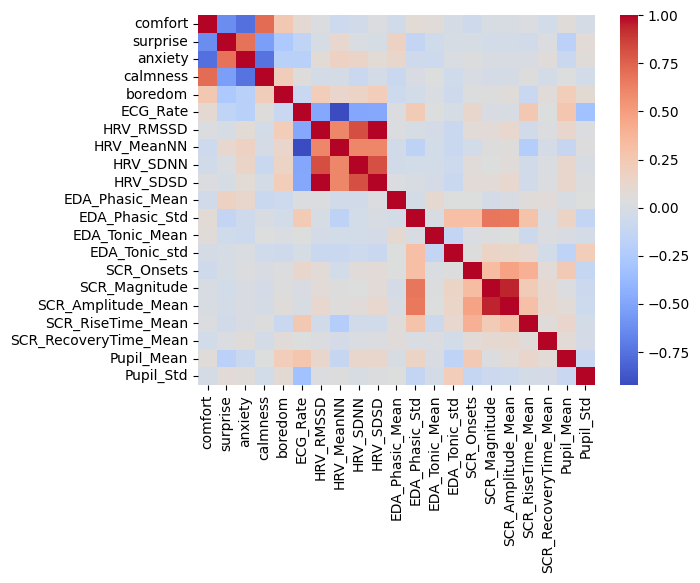

In [535]:
# create the correlation matrix
corr_matrix = df.corr()

# create a heatmap using seaborn
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False)

In [536]:
# extract the features and target variable
X = df.drop(["surprise", "anxiety", "boredom", "calmness", "comfort"], axis=1)
y = df[["surprise", "anxiety", "boredom", "calmness", "comfort"]]

In [537]:
X.shape

(3108, 16)

In [538]:
y.shape

(3108, 5)

In [539]:
# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [540]:
# initialize the StandardScaler object
scaler = StandardScaler()

# fit and transform the data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [541]:
pd.DataFrame(X_train_scaled, columns=X_train.columns).head()

,ECG_Rate,HRV_RMSSD,HRV_MeanNN,HRV_SDNN,HRV_SDSD,EDA_Phasic_Mean,EDA_Phasic_Std,EDA_Tonic_Mean,EDA_Tonic_std,SCR_Onsets,SCR_Magnitude,SCR_Amplitude_Mean,SCR_RiseTime_Mean,SCR_RecoveryTime_Mean,Pupil_Mean,Pupil_Std
0,-0.244376,-0.254118,0.165846,0.361464,-0.285381,0.082637,-0.744477,-1.246375,-0.477693,1.518832,-0.285052,-0.007336,2.144779,0.519211,-0.109594,0.311000
1,0.355045,-0.374625,-0.440317,-0.426353,-0.383572,-1.445411,-0.436741,-0.872552,-0.194823,-0.575353,-0.742293,-0.705255,-0.580519,-0.429252,0.391478,-0.433932
2,-0.554254,-0.307351,0.578346,-0.110911,-0.309264,-0.467310,-0.017962,1.955665,-0.433965,0.471739,0.360202,0.481242,-0.196861,-0.273700,-0.658658,0.069395
3,-0.742324,-0.150509,0.825680,-0.074002,-0.165132,-2.505393,1.279548,0.378825,-0.109201,0.471739,-0.224516,-0.340804,-0.461453,-0.401786,-1.159085,0.006751
4,0.043461,-0.109079,-0.132508,0.387429,-0.109063,1.613259,-0.336680,-1.323996,-0.250276,1.518832,-0.259566,-0.149663,-0.289468,0.000769,-1.074712,-0.695316


In [542]:
print("length of X_train_scaled:", len(X_train_scaled))
print("length of y_train:", len(y_train))
print("length of X_test_scaled:", len(X_test_scaled))
print("length of y_test:", len(y_test))

length of X_train_scaled: 2486
length of y_train: 2486
length of X_test_scaled: 622
length of y_test: 622


In [543]:
def compute_ccc(y_test, y_pred):
    """
    Compute the Concordance correlation coefficient between y_true and y_pred.
    """
    mean_test = np.mean(y_test)
    mean_pred = np.mean(y_pred)
    var_test = np.var(y_test)
    var_pred = np.var(y_pred)
    covar = np.cov(y_test, y_pred)[0, 1]
    rho_c = 2 * covar / (var_test + var_pred + (mean_test - mean_pred) ** 2)
    return rho_c

In [544]:
# initialize and fit the random forest regressor model
# model = RandomForestRegressor(n_estimators=16, random_state=42)
# model.fit(X_train_scaled, y_train)

In [ ]:
# # Create a Random Forest model
# rf = RandomForestRegressor()

# Define the parameter grid for Grid Search
param_grid = {
    'n_estimators': [400]
}

# Perform Grid Search to find the best value of n_estimators
grid_search = GridSearchCV(estimator=RandomForestRegressor(), param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Print the best value of n_estimators
print("Best value of n_estimators:", grid_search.best_params_['n_estimators'])

# Save the best parameters to a file
best_params = grid_search.best_params_
with open('./best_params.json', 'w') as f:
    json.dump(best_params, f)

# Evaluate the model with the best value of n_estimators on the testing set
y_pred = grid_search.predict(X_test)

In [ ]:
rf = RandomForestRegressor(n_estimators=400, random_state=42)
rf.fit(X_train_scaled, y_train)

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)

# Extract the feature names from the DataFrame columns
feature_names = X_train_scaled_df.columns.tolist()

# Get feature importances from the trained model
importances = rf.feature_importances_

# summarize feature importance
for i,v in enumerate(importances):
 print('Feature: %0d, Score: %.5f' % (i,v))

# plot feature importance
plt.bar([x for x in range(len(importances))], importances)
plt.show()

In [ ]:
# Extract the feature names from the DataFrame columns
feature_names = X_train_scaled_df.columns.tolist()

# Sort the feature importances in descending order
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(X_train.shape[1]):
    print("%d. %s (%f)" % (f + 1, feature_names[indices[f]], importances[indices[f]]))

# Plot the feature importances
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices], color="b", align="center")
plt.xticks(range(X_train.shape[1]), [feature_names[i] for i in indices], rotation=45, ha='right')
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [ ]:
# make predictions on the testing set
# y_pred = model.predict(X_test_scaled)

In [ ]:
print("Shape of y_pred:", y_pred.shape)
print("Shape of y_test:", y_test.shape)

In [ ]:
# evaluate the model using root mean squared error
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
ccc = compute_ccc(y_test, y_pred)

print("Mean squared error:", mse)
print("Root Mean squared error:", rmse)
print("Mean Absolute error:", mae)
# print("Pearson correlation:", pearsonr(y_test, y_pred))
print("Concordance correlation coefficients (CCC):")
print(ccc)
